# DoorDash Uplift Modeling

Notebook version of uplift modeling pipeline (T-learner + Causal Tree) for the app download bottom sheet experiment.

In [1]:
# !pip install xgboost scikit-uplift

In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
# from causalml.inference.tree import CausalRandomForestRegressor
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest



# Config
DATA_PATH = "app_download_personalization_filtered.csv"  # <-- replace with your CSV path
TARGET_COL = "DEVICE_ID_PLACED_AN_ORDER_REAL_TIME" # was an order placed
TREATMENT_COL = "DEVICE_ID_SHOW_APP_DOWNLOAD_BOTTOM_SHEET_REAL_TIME" # was the bottom sheet shown
DROP_COLS = []
TEST_SIZE = 0.2
RANDOM_STATE = 42
TREE_MAX_DEPTH = 5
TREE_MIN_SAMPLES_LEAF = 2000
N_BUCKETS = 10


In [3]:

df_raw = pd.read_csv(DATA_PATH)

features = [
    'CONSUMER_ID_MOBILE_WEB_ORDERS_RECENT_90_DAYS',
    'CONSUMER_ID_TOTAL_ORDERS_RECENT_90_DAYS',
    'CX360_AVG_ORDER_INTERVAL_DAYS',
    'CX360_AVG_VP_LIFETIME',
    'CX360_BREAKFAST_COUNT_LIFETIME',
    'CX360_IS_CURRENT_DASHPASS',
    'CX360_IS_EVER_DASHPASS',
    'CX360_IS_SUMA_CLUSTER_ACCOUNT_MOST_ACTIVE_RECENT',
    'CX360_LATE_NIGHT_COUNT_LIFETIME',
    'CX360_LUNCH_COUNT_LIFETIME',
    'CX360_ORDER_COUNT_LIFETIME',
    'DEVICE_ID_HAS_LOGGED_IN_RECENT_28_DAYS',
    'DEVICE_ID_IS_ACTIVE_RECENT_28_DAYS',
    'DEVICE_ID_IS_AUTO_LOGGED_IN_MOST_RECENT_SESSION',
    'DEVICE_ID_ORDERS_RECENT_28_DAYS',
    'DEVICE_ID_PLACED_ORDER_MOST_RECENT_SESSION',
    'DEVICE_ID_RECENCY_MOST_RECENT_SESSION',
    'DEVICE_ID_SESSIONS_RECENT_28_DAYS',
    'HAS_ASSOCIATED_CONSUMER_ID',
    'FIRST_EXPOSURE_HOUR'
]

categorical_features = [
    'CX360_LIFESTAGE',
    'CX360_FREQ_CATEGORY',
    'DEVICE_ID_GENERAL_TRAFFIC_TYPE_MOST_RECENT_SESSION',
    'DEVICE_ID_GENERAL_TRAFFIC_TYPE_REAL_TIME',
    'CX360_RECENCY_ORDER_FREQUENCY_CATEGORY'
]

df = df_raw[features + [TARGET_COL, TREATMENT_COL]].copy()
df[TARGET_COL] = df[TARGET_COL].astype(int)
df[TREATMENT_COL] = df[TREATMENT_COL].astype(int)

df_all = df_raw[features + categorical_features + [TARGET_COL, TREATMENT_COL]].copy()
df_all[TARGET_COL] = df_all[TARGET_COL].astype(int)
df_all[TREATMENT_COL] = df_all[TREATMENT_COL].astype(int)




In [4]:
df_all = pd.get_dummies(df_all, columns=["CX360_LIFESTAGE", "CX360_FREQ_CATEGORY"], dtype=bool)
df_all = pd.get_dummies(df_all, columns=["DEVICE_ID_GENERAL_TRAFFIC_TYPE_REAL_TIME", "DEVICE_ID_GENERAL_TRAFFIC_TYPE_MOST_RECENT_SESSION"], prefix=["DEVICE_ID_CHANNEL_REAL_TIME", "DEVICE_ID_CHANNEL_MOST_RECENT_SESSION"], dtype=bool)
mapping = {"Low": 0, "Medium": 1, "High": 2}
df_all["CX360_RECENCY_ORDER_FREQUENCY_CATEGORY"] = (
    df_all["CX360_RECENCY_ORDER_FREQUENCY_CATEGORY"].map(mapping)
)

In [5]:
# df_all = df_all.dropna(subset=df_all.columns)
# df = df_clean.dropna(subset=df_clean.columns)

In [6]:
print("Rows:", len(df_all), "Cols:", df_all.shape[1])
print("\nTarget distribution:")
print(df_all[TARGET_COL].value_counts(normalize=True))
print("\nTreatment distribution:")
print(df_all[TREATMENT_COL].value_counts(normalize=True))
print("\nConversion rate by group:")
print(df_all.groupby(TREATMENT_COL)[TARGET_COL].mean())


Rows: 1822378 Cols: 66

Target distribution:
DEVICE_ID_PLACED_AN_ORDER_REAL_TIME
0    0.798418
1    0.201582
Name: proportion, dtype: float64

Treatment distribution:
DEVICE_ID_SHOW_APP_DOWNLOAD_BOTTOM_SHEET_REAL_TIME
0    0.500092
1    0.499908
Name: proportion, dtype: float64

Conversion rate by group:
DEVICE_ID_SHOW_APP_DOWNLOAD_BOTTOM_SHEET_REAL_TIME
0    0.201581
1    0.201583
Name: DEVICE_ID_PLACED_AN_ORDER_REAL_TIME, dtype: float64


In [7]:
feature_cols_all = [c for c in df.columns if c not in set([TARGET_COL, TREATMENT_COL] + DROP_COLS)]
cat_cols_all = [c for c in feature_cols_all if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
num_cols_all = [c for c in feature_cols_all if c not in cat_cols_all]

feature_cols = [c for c in df.columns if c not in set([TARGET_COL, TREATMENT_COL] + DROP_COLS)]
cat_cols = [c for c in feature_cols if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
num_cols = [c for c in feature_cols if c not in cat_cols]

# cat_pipe = Pipeline([
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("ohe", OneHotEncoder(handle_unknown="ignore"))
# ])
# num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])

# pre_all = ColumnTransformer([
#     ("cat", cat_pipe, cat_cols_all),
#     ("num", num_pipe, num_cols_all)
# ])

# pre = ColumnTransformer([
#     ("cat", cat_pipe, cat_cols),
#     ("num", num_pipe, num_cols)
# ])


In [25]:
X_all = df_all[feature_cols_all]
y_all = df_all[TARGET_COL].values
t_all = df_all[TREATMENT_COL].values
stratify_col = pd.Series(list(zip(y_all, t_all)))

X_train_all, X_val_all, y_train_all, y_val_all, t_train_all, t_val_all = train_test_split(
    X_all, y_all, t_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_col
)

X = df[feature_cols]
y = df[TARGET_COL].values
t = df[TREATMENT_COL].values

X_train, X_val, y_train, y_val, t_train, t_val = train_test_split(
    X, y, t, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)


In [9]:
# # All features including categorical features : T-LEARNER
# model_t_all = Pipeline([("pre", pre_all), ("clf", LogisticRegression(solver="saga", max_iter=500, n_jobs=-1, random_state=RANDOM_STATE))])
# model_c_all = Pipeline([("pre", pre_all), ("clf", LogisticRegression(solver="saga", max_iter=500, n_jobs=-1, random_state=RANDOM_STATE))])

# model_t_all.fit(X_train_all[t_train_all==1], y_train_all[t_train_all==1])
# model_c_all.fit(X_train_all[t_train_all==0], y_train_all[t_train_all==0])

# uplift_val_t_all = model_t_all.predict_proba(X_val_all)[:,1]
# uplift_val_c_all = model_c_all.predict_proba(X_val_all)[:,1]
# uplift_tlearner_all = uplift_val_t_all - uplift_val_c_all

# print("ALL FEATURES: Sample uplift predictions (T-learner):", uplift_tlearner_all[:10])


In [10]:
# # No categorical features : T-LEARNER
# model_t = Pipeline([("pre", pre), ("clf", LogisticRegression(solver="saga", max_iter=500, n_jobs=-1, random_state=RANDOM_STATE))])
# model_c = Pipeline([("pre", pre), ("clf", LogisticRegression(solver="saga", max_iter=500, n_jobs=-1, random_state=RANDOM_STATE))])

# model_t.fit(X_train[t_train==1], y_train[t_train==1])
# model_c.fit(X_train[t_train==0], y_train[t_train==0])

# uplift_val_t = model_t.predict_proba(X_val)[:,1]
# uplift_val_c = model_c.predict_proba(X_val)[:,1]
# uplift_tlearner = uplift_val_t - uplift_val_c

# print("NO CAT FEATURES: Sample uplift predictions (T-learner):", uplift_tlearner[:10])


In [28]:
df_lgbm = df_raw[features + categorical_features + [TARGET_COL, TREATMENT_COL]].copy()

# Pick candidate columns: bool, object, or category
candidate_cols = df_lgbm.select_dtypes(include=["bool", "object", "category"]).columns

# Function to check if a column is "boolean-like"
def is_boolean_like(series):
    unique_vals = set(series.dropna().unique())
    valid = {True, False, "True", "False", "true", "false", 1, 0}
    return unique_vals.issubset(valid)

# Filter only boolean-like columns
bool_cols = [col for col in candidate_cols if is_boolean_like(df_lgbm[col])]

# Convert boolean-like columns to proper bool dtype with NA support
for col in bool_cols:
    df_lgbm[col] = df_lgbm[col].map(
        lambda x: True if str(x).lower() == "true" 
                  else False if str(x).lower() == "false" 
                  else pd.NA
    ).astype("boolean")  # pandas nullable BooleanDtype

# Convert categorical features to category dtype
for col in categorical_features:
    df_lgbm[col] = df_lgbm[col].astype('category')

mapping = {"Low": 0, "Medium": 1, "High": 2}
df_lgbm["CX360_RECENCY_ORDER_FREQUENCY_CATEGORY"] = (
    df_lgbm["CX360_RECENCY_ORDER_FREQUENCY_CATEGORY"].map(mapping)
)

X_lgbm = df_lgbm[features + categorical_features]
y_lgbm = df_lgbm[TARGET_COL].values
t_lgbm = df_lgbm[TREATMENT_COL].values

stratify_col = pd.Series(list(zip(y_lgbm, t_lgbm)))


X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm, t_train_lgbm, t_test_lgbm = train_test_split(
    X_lgbm, y_lgbm, t_lgbm, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_col
)


y_val_lgbm = y_test_lgbm
t_val_lgbm = t_test_lgbm
X_val_lgbm = X_test_lgbm



In [29]:
X_train_lgbm.shape, y_train_lgbm.shape, t_train_lgbm.shape


((1457902, 25), (1457902,), (1457902,))

In [31]:
y_train_treated = y_train_lgbm[t_train_lgbm == 1].mean()
y_train_control = y_train_lgbm[t_train_lgbm == 0].mean()
ate_train = y_train_treated - y_train_control

print("=" * 60)
print("TRAINING SET - Average Treatment Effect")
print("=" * 60)
print(f"Average outcome (Y) for TREATED (T=1):  {y_train_treated:.4f}")
print(f"Average outcome (Y) for CONTROL (T=0):  {y_train_control:.4f}")
print(f"Average Treatment Effect (ATE):         {ate_train:.4f}")
print(f"Relative Lift:                          {(ate_train/y_train_control)*100:.2f}%")
print()

# TEST SET
y_test_treated = y_test_lgbm[t_test_lgbm == 1].mean()
y_test_control = y_test_lgbm[t_test_lgbm == 0].mean()
ate_test = y_test_treated - y_test_control

print("=" * 60)
print("TEST SET - Average Treatment Effect")
print("=" * 60)
print(f"Average outcome (Y) for TREATED (T=1):  {y_test_treated:.4f}")
print(f"Average outcome (Y) for CONTROL (T=0):  {y_test_control:.4f}")
print(f"Average Treatment Effect (ATE):         {ate_test:.4f}")
print(f"Relative Lift:                          {(ate_test/y_test_control)*100:.2f}%")
print()

# SUMMARY
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Sample sizes:")
print(f"  Train: {len(y_train_lgbm):,} ({t_train_lgbm.sum():,} treated, {(~t_train_lgbm.astype(bool)).sum():,} control)")
print(f"  Test:  {len(y_test_lgbm):,} ({t_test_lgbm.sum():,} treated, {(~t_test_lgbm.astype(bool)).sum():,} control)")

TRAINING SET - Average Treatment Effect
Average outcome (Y) for TREATED (T=1):  0.2016
Average outcome (Y) for CONTROL (T=0):  0.2016
Average Treatment Effect (ATE):         0.0000
Relative Lift:                          0.00%

TEST SET - Average Treatment Effect
Average outcome (Y) for TREATED (T=1):  0.2016
Average outcome (Y) for CONTROL (T=0):  0.2016
Average Treatment Effect (ATE):         -0.0000
Relative Lift:                          -0.00%

SUMMARY
Sample sizes:
  Train: 1,457,902 (728,818 treated, 729,084 control)
  Test:  364,476 (182,204 treated, 182,272 control)


In [32]:
# LightGBM - ALL FEATURES
    
model_lgbm_t = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.065,
    num_leaves=50,
    n_estimators=100,
    random_state=RANDOM_STATE,
    is_unbalance=True,
    # scale_pos_weight=len(y_train_lgbm[t_train_lgbm==1 and y_train_lgbm==0]) / len(y_train_lgbm[t_train_lgbm==1 and y_train_lgbm==1])
)

model_lgbm_c = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.065,
    num_leaves=50,
    n_estimators=500,
    random_state=RANDOM_STATE,
    is_unbalance=True,
    # scale_pos_weight=len(y_train_lgbm[t_train_lgbm==0 and y_train_lgbm==0]) / len(y_train_lgbm[t_train_lgbm==0 and y_train_lgbm==1])
)

model_lgbm_t.fit(X_train_lgbm[t_train_lgbm==1], y_train_lgbm[t_train_lgbm==1])
model_lgbm_c.fit(X_train_lgbm[t_train_lgbm==0], y_train_lgbm[t_train_lgbm==0])

uplift_test_t_lgbm = model_lgbm_t.predict_proba(X_test_lgbm)[:,1]
uplift_test_c_lgbm = model_lgbm_c.predict_proba(X_test_lgbm)[:,1]
uplift_lgbm = uplift_test_t_lgbm - uplift_test_c_lgbm

print("ALL FEATURES: Sample uplift predictions (LightGBM):", uplift_lgbm[:10])


[LightGBM] [Info] Number of positive: 146918, number of negative: 581900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 728818, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201584 -> initscore=-1.376424
[LightGBM] [Info] Start training from score -1.376424
[LightGBM] [Info] Number of positive: 146969, number of negative: 582115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2446
[LightGBM] [Info] Number of data points in the train set: 729084, number of used features: 25
[LightGBM] [

AUC (Treat): 0.813 | AUC (Control): 0.821


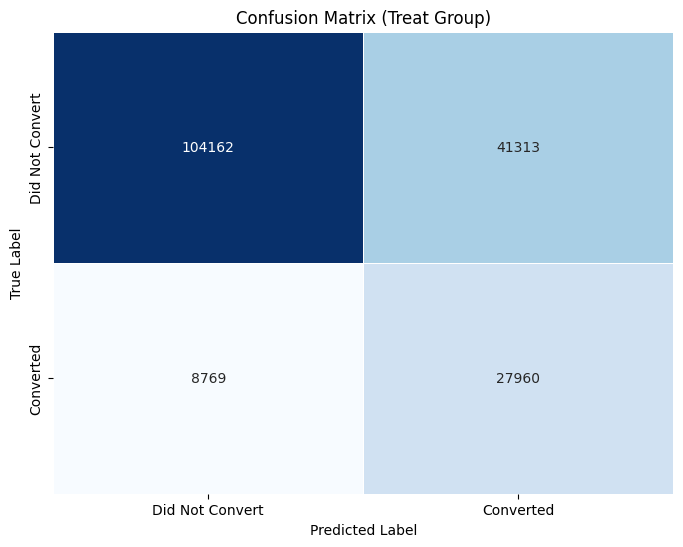

Confusion Matrix (Treat): 
[[104162  41313]
 [  8769  27960]]
Confusion Matrix (Control): 
[[104884  40645]
 [  8512  28231]]


In [33]:
from sklearn.metrics import roc_auc_score, confusion_matrix
auc_treat = roc_auc_score(y_val_lgbm[t_val_lgbm==1], model_lgbm_t.predict_proba(X_val_lgbm[t_val_lgbm==1])[:, 1])
auc_control = roc_auc_score(y_val_lgbm[t_val_lgbm==0], model_lgbm_c.predict_proba(X_val_lgbm[t_val_lgbm==0])[:, 1])
print(f"AUC (Treat): {auc_treat:.3f} | AUC (Control): {auc_control:.3f}")

cm = confusion_matrix(
    y_val_lgbm[t_val_lgbm==1], 
    model_lgbm_t.predict(X_val_lgbm[t_val_lgbm==1])
)
labels = ['Did Not Convert', 'Converted'] 
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,               
    fmt='d',                  
    cmap='Blues',             
    linewidths=.5,            
    cbar=False,               
    xticklabels=labels,       
    yticklabels=labels        
)

plt.title('Confusion Matrix (Treat Group)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"Confusion Matrix (Treat): \n{confusion_matrix(y_val_lgbm[t_val_lgbm==1], model_lgbm_t.predict(X_val_lgbm[t_val_lgbm==1]))}")
print(f"Confusion Matrix (Control): \n{confusion_matrix(y_val_lgbm[t_val_lgbm==0], model_lgbm_c.predict(X_val_lgbm[t_val_lgbm==0]))}")


In [34]:
from xgboost import XGBClassifier

# XGBoost - ALL FEATURES

model_xgb_t = XGBClassifier(
    objective="binary:logistic",
    
    learning_rate=0.065,
    max_depth=7,          # similar to LightGBM's num_leaves (depth ≈ log2(leaves))
    n_estimators=100,
    random_state=RANDOM_STATE,
    scale_pos_weight=len(y_train_lgbm[(t_train_lgbm==1) & (y_train_lgbm==0)]) / 
                     max(1, len(y_train_lgbm[(t_train_lgbm==1) & (y_train_lgbm==1)])),
    use_label_encoder=False,
    eval_metric="logloss",
    enable_categorical=True
)

model_xgb_c = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.065,
    max_depth=7,
    n_estimators=500,
    random_state=RANDOM_STATE,
    scale_pos_weight=len(y_train_lgbm[(t_train_lgbm==0) & (y_train_lgbm==0)]) / 
                     max(1, len(y_train_lgbm[(t_train_lgbm==0) & (y_train_lgbm==1)])),
    use_label_encoder=False,
    eval_metric="logloss",
    enable_categorical=True
)

# Fit treated and control models separately
model_xgb_t.fit(X_train_lgbm[t_train_lgbm==1], y_train_lgbm[t_train_lgbm==1])
model_xgb_c.fit(X_train_lgbm[t_train_lgbm==0], y_train_lgbm[t_train_lgbm==0])

# Predict uplift = difference in predicted probabilities
uplift_val_t_xgb = model_xgb_t.predict_proba(X_val_lgbm)[:,1]
uplift_val_c_xgb = model_xgb_c.predict_proba(X_val_lgbm)[:,1]
uplift_xgb = uplift_val_t_xgb - uplift_val_c_xgb

print("ALL FEATURES: Sample uplift predictions (XGBoost):", uplift_xgb[:10])

/Users/fiona.fan/Documents/fiona_analyses/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:07:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/fiona.fan/Documents/fiona_analyses/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ALL FEATURES: Sample uplift predictions (XGBoost): [ 0.10101455  0.01291467 -0.0106228  -0.00216337  0.0151996  -0.00014055
  0.01594885  0.01310343  0.01498839  0.00442845]


AUC (Treat): 0.813 | AUC (Control): 0.820


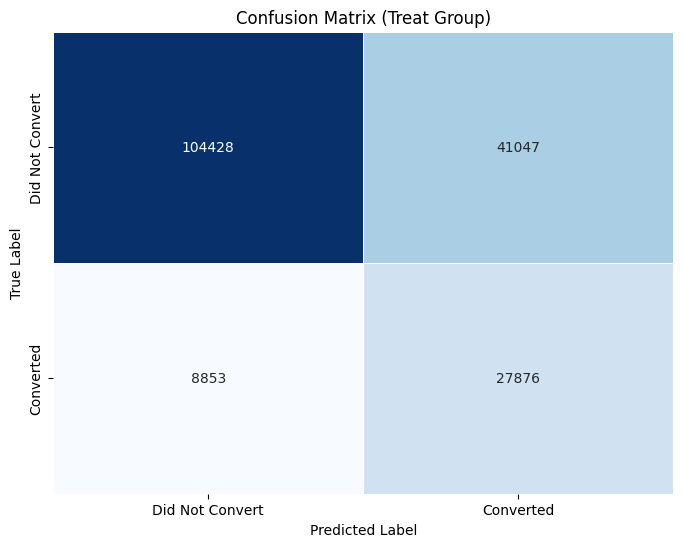

Confusion Matrix (Treat): 
[[104428  41047]
 [  8853  27876]]
Confusion Matrix (Control): 
[[105278  40251]
 [  8643  28100]]


In [35]:
auc_treat = roc_auc_score(y_val_lgbm[t_val_lgbm==1], model_xgb_t.predict_proba(X_val_lgbm[t_val_lgbm==1])[:, 1])
auc_control = roc_auc_score(y_val_lgbm[t_val_lgbm==0], model_xgb_c.predict_proba(X_val_lgbm[t_val_lgbm==0])[:, 1])
print(f"AUC (Treat): {auc_treat:.3f} | AUC (Control): {auc_control:.3f}")

cm = confusion_matrix(
    y_val_lgbm[t_val_lgbm==1], 
    model_xgb_t.predict(X_val_lgbm[t_val_lgbm==1])
)
labels = ['Did Not Convert', 'Converted'] 
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,               
    fmt='d',                  
    cmap='Blues',             
    linewidths=.5,            
    cbar=False,               
    xticklabels=labels,       
    yticklabels=labels        
)

plt.title('Confusion Matrix (Treat Group)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"Confusion Matrix (Treat): \n{confusion_matrix(y_val_lgbm[t_val_lgbm==1], model_xgb_t.predict(X_val_lgbm[t_val_lgbm==1]))}")
print(f"Confusion Matrix (Control): \n{confusion_matrix(y_val_lgbm[t_val_lgbm==0], model_xgb_c.predict(X_val_lgbm[t_val_lgbm==0]))}")


In [36]:
# Causal Tree - ALL FEATURES
def transformed_outcome(y, t, p):
    eps = 1e-6
    p = np.clip(p, eps, 1-eps)
    return y * (t/p) - y * ((1-t)/(1-p))

p = t_train_all.mean()
tau_train_all = transformed_outcome(y_train_all, t_train_all, p)

causal_tree_all = Pipeline([ ("tree", DecisionTreeRegressor(max_depth=TREE_MAX_DEPTH+5, min_samples_leaf=TREE_MIN_SAMPLES_LEAF, random_state=RANDOM_STATE))])
causal_tree_all.fit(X_train_all, tau_train_all)
uplift_tree_all = causal_tree_all.predict(X_val_all)

print("ALL FEATURES: Sample uplift predictions (Causal Tree):", uplift_tree_all[:10])



ALL FEATURES: Sample uplift predictions (Causal Tree): [0.00098658 0.00098658 0.00098658 0.00098658 0.00098658 0.00098658
 0.00098658 0.00098658 0.00098658 0.00098658]


In [37]:
p = t_train.mean()
tau_train = transformed_outcome(y_train, t_train, p)

causal_tree = Pipeline([ ("tree", DecisionTreeRegressor(max_depth=TREE_MAX_DEPTH+5, min_samples_leaf=TREE_MIN_SAMPLES_LEAF, random_state=RANDOM_STATE))])
causal_tree.fit(X_train, tau_train)
uplift_tree = causal_tree.predict(X_val)

print("NO CAT FEATURES: Sample uplift predictions (Causal Tree):", uplift_tree[:10])

NO CAT FEATURES: Sample uplift predictions (Causal Tree): [0.00049633 0.00049633 0.00049633 0.00049633 0.00049633 0.00049633
 0.00049633 0.00049633 0.00049633 0.00049633]


In [38]:

def qini_uplift_curves(y_true, t, uplift, n_buckets=10):
    df_eval = pd.DataFrame({"y": y_true, "t": t, "uplift": uplift})
    df_eval = df_eval.sort_values("uplift", ascending=False).reset_index(drop=True)
    df_eval["bucket"] = pd.qcut(df_eval.index, n_buckets, labels=False, duplicates="drop") + 1

    bucket_stats = df_eval.groupby("bucket").apply(
        lambda g: pd.Series({
            "count": len(g),
            "treated": g["t"].sum(),
            "control": len(g)-g["t"].sum(),
            "y_treated": g.loc[g["t"]==1,"y"].sum(),
            "y_control": g.loc[g["t"]==0,"y"].sum()
        })
    )
    return bucket_stats


# bucket_t_all = qini_uplift_curves(y_val_all, t_val_all, uplift_tlearner_all)
# bucket_t = qini_uplift_curves(y_val, t_val, uplift_tlearner)

bucket_t_lgbm = qini_uplift_curves(y_test_lgbm, t_test_lgbm, uplift_lgbm)

bucket_t_xgb = qini_uplift_curves(y_test_lgbm, t_test_lgbm, uplift_xgb)

bucket_tree_all = qini_uplift_curves(y_val_all, t_val_all, uplift_tree_all)
bucket_tree = qini_uplift_curves(y_val, t_val, uplift_tree)

bucket_t_lgbm, bucket_tree_all, bucket_tree


/var/folders/m7/nh1p1bb5607_g6htqfn80v780000gn/T/ipykernel_95298/3596970861.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucket_stats = df_eval.groupby("bucket").apply(
/var/folders/m7/nh1p1bb5607_g6htqfn80v780000gn/T/ipykernel_95298/3596970861.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucket_stats = df_eval.groupby("bucket").apply(
/var/folders/m7/nh1p1bb5607_g6htqfn80v780000gn/T/ipykernel_95298/359

(        count  treated  control  y_treated  y_control
 bucket                                               
 1       36448    18060    18388       3983       3975
 2       36448    18341    18107       2260       2231
 3       36447    18124    18323       1856       1803
 4       36448    18217    18231       2135       2060
 5       36447    18193    18254       2821       2771
 6       36448    18395    18053       2518       2533
 7       36447    18235    18212       3740       3747
 8       36448    18163    18285       4111       4132
 9       36447    18193    18254       6273       6290
 10      36448    18283    18165       7032       7201,
         count  treated  control  y_treated  y_control
 bucket                                               
 1       36448    18289    18159       3443       3433
 2       36448    18142    18306       3413       3444
 3       36447    18257    18190       3403       3443
 4       36448    18342    18106       3394       3306
 5       

In [39]:
from sklift.metrics import qini_auc_score, uplift_at_k
from sklift.viz import plot_qini_curve, plot_uplift_curve

models = [
    ("LightGBM", uplift_lgbm, y_val_lgbm, t_val_lgbm),
    ("XGBoost", uplift_xgb, y_val_lgbm, t_val_lgbm),
    ("Causal Tree All Features", uplift_tree_all, y_val_all, t_val_all),
    ("Causal Tree", uplift_tree, y_val, t_val)
]

results = []

for (name, preds, y_true, treatment) in models:
    # Qini coefficient
    qini = qini_auc_score(y_true, preds, treatment)

    # AUUC (approx via area under uplift curve)
    sorted_idx = np.argsort(-preds)
    y_sorted, t_sorted = np.array(y_true)[sorted_idx], np.array(treatment)[sorted_idx]

    treated = (t_sorted == 1)
    control = (t_sorted == 0)
    cum_treat = np.cumsum(y_sorted * treated) / max(1, treated.sum())
    cum_control = np.cumsum(y_sorted * control) / max(1, control.sum())
    uplift_curve = cum_treat - cum_control
    auuc = np.trapz(uplift_curve) / len(y_sorted)

    # Uplift at top-30%
    uplift_top_30 = uplift_at_k(y_true, preds, treatment, strategy="by_group", k=0.3)
    uplift_top_50 = uplift_at_k(y_true, preds, treatment, strategy="by_group", k=0.5)
    uplift_top_70 = uplift_at_k(y_true, preds, treatment, strategy="by_group", k=0.8)

    results.append({
        "Model": name,
        "Qini": qini,
        "AUUC": auuc,
        "Uplift@30%": uplift_top_30,
        "Uplift@50%": uplift_top_50,
        "Uplift@70%": uplift_top_70
    })

# Show results table
results_df = pd.DataFrame(results)
display(results_df)

# # Plot curves
# for name, preds, y_true, treatment in models:
#     plt.figure(figsize=(12,5))
#     plot_qini_curve(y_true, preds, treatment)
#     plt.title(f"Qini Curve - {name}")
#     plt.show()

#     plt.figure(figsize=(12,5))
#     plot_uplift_curve(y_true, preds, treatment)
#     plt.title(f"Uplift Curve - {name}")
#     plt.show()

,Model,Qini,AUUC,Uplift@30%,Uplift@50%,Uplift@70%
0,LightGBM,0.004837,0.000723,0.001920,0.002819,0.001486
1,XGBoost,0.004156,0.000560,0.001612,0.001614,0.001254
2,Causal Tree All Features,0.001811,0.000193,-0.001651,-0.000216,0.000426
3,Causal Tree,0.002502,0.001289,0.001054,0.002067,0.003290


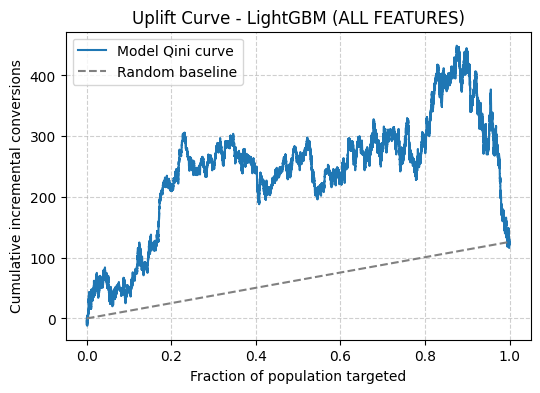

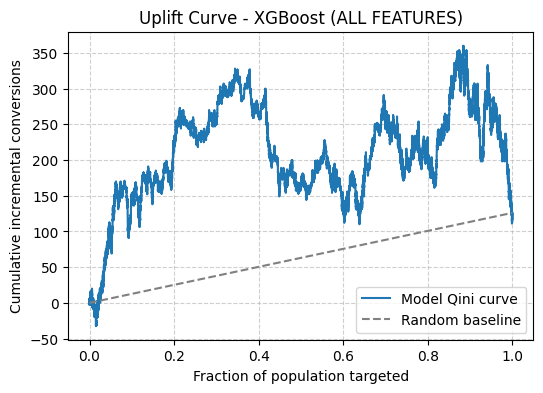

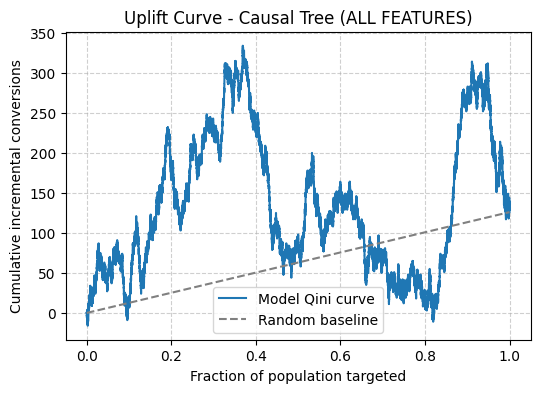

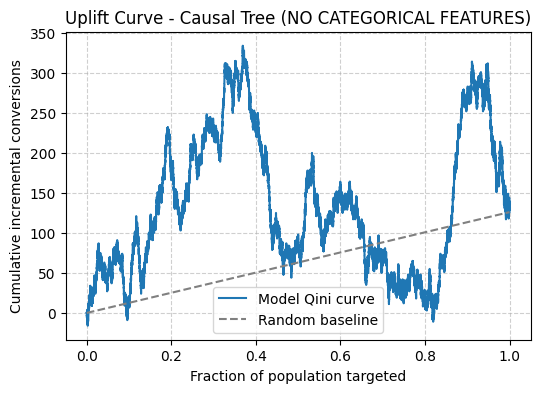

In [20]:
def plot_curve(uplift, title, cat_features=False):
    """
    Plots Qini curve: model vs random baseline.
    uplift: predicted uplift scores
    y_true: actual outcomes
    t: treatment indicator
    """
    # Sort users by predicted uplift (descending)
    order = np.argsort(-uplift)
    if cat_features:
        y_sorted = y_val_all[order]
        t_sorted = t_val_all[order]
    else:
        y_sorted = y_val[order]
        t_sorted = t_val[order]

    # Cumulative sums
    cum_y_t = np.cumsum(y_sorted * t_sorted)
    cum_y_c = np.cumsum(y_sorted * (1 - t_sorted))

    # Incremental effect at each step
    inc = cum_y_t - cum_y_c
    frac = np.arange(1, len(uplift) + 1) / len(uplift)

    # Random baseline = straight line from (0,0) to (1, total incremental effect)
    total_inc = inc[-1]
    baseline = frac * total_inc

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(frac, inc, label="Model Qini curve")
    plt.plot(frac, baseline, "--", color="gray", label="Random baseline")
    plt.title(title)
    plt.xlabel("Fraction of population targeted")
    plt.ylabel("Cumulative incremental conversions")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

# plot_curve(uplift_tlearner_all, "Uplift Curve - T-learner (ALL FEATURES)", cat_features=True)
# plot_curve(uplift_tlearner, "Uplift Curve - T-learner (NO CATEGORICAL FEATURES)", cat_features=False)
plot_curve(uplift_lgbm, "Uplift Curve - LightGBM (ALL FEATURES)", cat_features=True)
plot_curve(uplift_xgb, "Uplift Curve - XGBoost (ALL FEATURES)", cat_features=True)
plot_curve(uplift_tree_all, "Uplift Curve - Causal Tree (ALL FEATURES)", cat_features=True)
plot_curve(uplift_tree, "Uplift Curve - Causal Tree (NO CATEGORICAL FEATURES)", cat_features=False)


In [21]:
# Counts
n_t = (t_val == 1).sum()
n_c = (t_val == 0).sum()
y_t = y_val[t_val == 1].sum()
y_c = y_val[t_val == 0].sum()

# Conversion rates
p_t = y_t / n_t
p_c = y_c / n_c
diff = p_t - p_c

print(f"Treated conversion: {p_t:.4f} ({y_t}/{n_t})")
print(f"Control conversion: {p_c:.4f} ({y_c}/{n_c})")
print(f"Difference (ATE): {diff:.4f}")

# Two-proportion z-test
count = np.array([y_t, y_c])
nobs = np.array([n_t, n_c])
z_stat, p_val = proportions_ztest(count, nobs)

print(f"z-statistic: {z_stat:.2f}")
print(f"p-value: {p_val:.4g}")

Treated conversion: 0.2025 (36799/181701)
Control conversion: 0.2006 (36673/182775)
Difference (ATE): 0.0019
z-statistic: 1.41
p-value: 0.1573
